In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



In [2]:
#fix all seeds for random number generators
# Set seed value
seed_value = 9
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# TODO need to add session thing for tensorflow

# Read Depth Camera

In [3]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = frame/np.maximum(np.max(frame),255)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [4]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [5]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [6]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)


n_test = (24,30,31,32,33,35)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize)
    xtemp[i]=x_train

In [7]:
x_train.shape

(28044, 60, 80, 3)

In [8]:
# tlen = len(xtemp[0])-2 +len(xtemp[1])-2+len(xtemp[2])+len(xtemp[3]) #remove 2 samples from 24
# x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
# x_train[:len(xtemp[0])-2,:,:,:] = xtemp[0][:len(xtemp[0])-2,:,:,:]
# x_train[(len(xtemp[0])-2):,:,:,:] = xtemp[1][:len(xtemp[1])-2,:,:,:]

tlen = len(xtemp[0]) +len(xtemp[1])+len(xtemp[2])+len(xtemp[3])+len(xtemp[4])+len(xtemp[5]) #remove 2 samples from 24 and 3 from 25
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
xrun = len(xtemp[0])
x_train[:xrun,:,:,:] = xtemp[0][:xrun,:,:,:]
xrun1 = xrun + len(xtemp[1])
x_train[xrun:xrun1,:,:,:]=xtemp[1][:xrun1-xrun,:,:,:]
xrun2 = xrun1 + len(xtemp[2])
x_train[xrun1:xrun2,:,:,:] = xtemp[2][:xrun2-xrun1,:,:,:]
xrun3 = xrun2 + len(xtemp[3])
x_train[xrun2:xrun3,:,:,:] = xtemp[3][:xrun3-xrun2,:,:,:]
xrun4 = xrun3 + len(xtemp[4])
x_train[xrun3:xrun4,:,:,:] = xtemp[4][:xrun4-xrun3,:,:,:]
xrun5 = xrun4 + len(xtemp[5])
x_train[xrun4:xrun5,:,:,:] = xtemp[5][:xrun5-xrun4,:,:,:]

In [9]:
print(x_train.shape)
del xtemp

(82381, 60, 80, 3)


# read fcss data

In [10]:


n_test = (24,30,31,32,33,35)
date = ('11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020')
xfcss_gt = {}
yrun = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + "/" +test_str
    fcss_data_dir = data_dir + "/fcss_processed_leo_" + test_str + '_' + date[i] + '.txt'
    xfcss_gttemp = pd.read_csv(fcss_data_dir)
    xfcss_gt[i]=xfcss_gttemp
    if i==0:
        xfcss_train=xfcss_gttemp
    else:
        xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
del xfcss_gt

In [11]:
# tmpdata.head()

In [12]:
xfcss_train.shape

(82381, 6)

# Read Output Data


In [13]:
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# # data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
# #show_qtm_plot = True

# y_gt = read_output_data(qtm_file_data_dir,theta_interest).values
# theta_x = read_output_data(qtm_file_data_dir,'x').values
# theta_y = read_output_data(qtm_file_data_dir,'y').values
# theta_z = read_output_data(qtm_file_data_dir,'z').values

n_test = (24,30,31,32,33,35)
date = ('11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020')
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test[i]) + '_' + date[i] + '.txt'
    y_gttemp = read_output_data(qtm_file_data_dir,theta_interest).values
    y_gt[i]=y_gttemp
    
tlen = len(y_gt[0])+len(y_gt[1])+len(y_gt[2])+len(y_gt[3])+len(y_gt[4])+len(y_gt[5])
y_train = np.zeros((tlen,1))
xrun = len(y_gt[0])
y_train[:xrun] = y_gt[0][:xrun]
xrun1 = xrun + len(y_gt[1])
y_train[xrun:xrun1]=y_gt[1][:xrun1-xrun]
xrun2 = xrun1 + len(y_gt[2])
y_train[xrun1:xrun2] = y_gt[2][:xrun2-xrun1]
xrun3 = xrun2 + len(y_gt[3])
y_train[xrun2:xrun3] = y_gt[3][:xrun3-xrun2]
xrun4 = xrun3 + len(y_gt[4])
y_train[xrun3:xrun4] = y_gt[4][:xrun4-xrun3]
xrun5 = xrun4 + len(y_gt[5])
y_train[xrun4:xrun5] = y_gt[5][:xrun5-xrun4]
del y_gt

In [14]:
## Saturate output
def saturate(theta, min_val, max_val):
    for i in range(len(theta)):
        if theta[i] < min_val:
            theta[i] = min_val
            continue
        if theta[i] > max_val:
            theta[i] = max_val
            continue
    return theta
            
min_val = -50
max_val = 50
    
y_train = saturate(y_train, min_val, max_val)

In [15]:
print(x_train.shape)
print(xfcss_train.shape)
print(y_train.shape)

(82381, 60, 80, 3)
(82381, 6)
(82381, 1)


In [16]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [17]:
Trainset = x_train[rannums,:]
Trainset2 = xfcss_train.values[rannums,:]
Testset = x_train[test_set,:]
Testset2 = xfcss_train.values[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [18]:
sc_X2 = StandardScaler()
sc_y = StandardScaler()

In [19]:
Xtrainz = Trainset
Xtrainz2 = Trainset2
ytrainz = Trainy
X = Xtrainz
X2 = sc_X2.fit_transform(Xtrainz2)
y = sc_y.fit_transform(ytrainz)

In [20]:
#make validation data available to model.fit
Xvalid = Testset
Xvalid2 = sc_X2.transform(Testset2)
y_valid = Testy
y_valid = sc_y.transform(y_valid)


# Regress using Neural Network

In [21]:
x_train.shape

(82381, 60, 80, 3)

In [28]:
# Create Neural Netowrk
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(X.shape[1],)))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# #model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))          
# model.add(tf.keras.layers.Dense(100, activation='linear')) #added extra layer. probably overkill but want good results
# model.add(tf.keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mae',
#               metrics=['mse','mae'])
    
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # loss_fn(y_train[:1], predictions).numpy()
from keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, concatenate, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout, Reshape, Permute, Flatten
from keras.models import Model
dropout_rate = 0.2

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_start2 = Input(shape=(xfcss_train.shape[1],))
model_cnn = model_start
model_perc = model_start2

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Conv2D(filters=96, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Flatten()(model_cnn)
# model_perc = Flatten()(model_perc)
# model_cnn = Activation('relu')(model_cnn)

model_cnn = Dense(128)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

model_comb = concatenate([model_cnn,model_perc],axis=-1)

model_comb = Dense(100)(model_comb)
model_comb = Activation('relu')(model_comb)
model_comb = Dropout(dropout_rate)(model_comb)

output = Dense(1)(model_comb)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=[model_start,model_start2],outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 


In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 60, 80, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 60, 80, 16)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_5 (AveragePoo (None, 30, 40, 16)   0           activation_9[0][0]               
____________________________________________________________________________________________

In [30]:
epochs = int(30000)
batch_size = 256
history = model.fit([X,X2], y,batch_size=batch_size, epochs = epochs,callbacks = [callback],validation_data = ([Xvalid,Xvalid2], y_valid),verbose=2)

# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Train on 65904 samples, validate on 16477 samples
Epoch 1/30000
 - 8s - loss: 0.5318 - mse: 0.6600 - mae: 0.5318 - val_loss: 0.4672 - val_mse: 0.5071 - val_mae: 0.4672
Epoch 2/30000
 - 8s - loss: 0.4494 - mse: 0.4905 - mae: 0.4494 - val_loss: 0.4047 - val_mse: 0.4170 - val_mae: 0.4047
Epoch 3/30000
 - 8s - loss: 0.4120 - mse: 0.4300 - mae: 0.4120 - val_loss: 0.3757 - val_mse: 0.3744 - val_mae: 0.3757
Epoch 4/30000
 - 8s - loss: 0.3890 - mse: 0.3997 - mae: 0.3890 - val_loss: 0.3568 - val_mse: 0.3506 - val_mae: 0.3568
Epoch 5/30000
 - 8s - loss: 0.3744 - mse: 0.3811 - mae: 0.3744 - val_loss: 0.3544 - val_mse: 0.3452 - val_mae: 0.3544
Epoch 6/30000
 - 8s - loss: 0.3615 - mse: 0.3621 - mae: 0.3615 - val_loss: 0.3416 - val_mse: 0.3360 - val_mae: 0.3416
Epoch 7/30000
 - 8s - loss: 0.3523 - mse: 0.3497 - mae: 0.3523 - val_loss: 0.3304 - val_mse: 0.3176 - val_mae: 0.3304
Epoch 8/30000
 - 8s - loss: 0.3427 - mse: 0.3385 - mae: 0.3427 - val_loss: 0.3230 - val_mse: 0.3067 - val_mae: 0.3230
Epoch 

Epoch 70/30000
 - 8s - loss: 0.1873 - mse: 0.1336 - mae: 0.1873 - val_loss: 0.1855 - val_mse: 0.1252 - val_mae: 0.1855
Epoch 71/30000
 - 8s - loss: 0.1856 - mse: 0.1321 - mae: 0.1856 - val_loss: 0.1847 - val_mse: 0.1254 - val_mae: 0.1847
Epoch 72/30000
 - 8s - loss: 0.1856 - mse: 0.1314 - mae: 0.1856 - val_loss: 0.1858 - val_mse: 0.1292 - val_mae: 0.1858
Epoch 73/30000
 - 8s - loss: 0.1847 - mse: 0.1301 - mae: 0.1847 - val_loss: 0.1842 - val_mse: 0.1232 - val_mae: 0.1842
Epoch 74/30000
 - 8s - loss: 0.1831 - mse: 0.1279 - mae: 0.1831 - val_loss: 0.1808 - val_mse: 0.1222 - val_mae: 0.1808
Epoch 75/30000
 - 8s - loss: 0.1833 - mse: 0.1280 - mae: 0.1833 - val_loss: 0.1836 - val_mse: 0.1243 - val_mae: 0.1836
Epoch 76/30000
 - 8s - loss: 0.1819 - mse: 0.1266 - mae: 0.1819 - val_loss: 0.1793 - val_mse: 0.1203 - val_mae: 0.1793
Epoch 77/30000
 - 8s - loss: 0.1799 - mse: 0.1245 - mae: 0.1799 - val_loss: 0.1760 - val_mse: 0.1173 - val_mae: 0.1760
Epoch 78/30000
 - 8s - loss: 0.1812 - mse: 0.125

Epoch 139/30000
 - 8s - loss: 0.1503 - mse: 0.0903 - mae: 0.1503 - val_loss: 0.1621 - val_mse: 0.1053 - val_mae: 0.1621
Epoch 140/30000
 - 8s - loss: 0.1509 - mse: 0.0901 - mae: 0.1509 - val_loss: 0.1697 - val_mse: 0.1098 - val_mae: 0.1697
Epoch 141/30000
 - 8s - loss: 0.1501 - mse: 0.0899 - mae: 0.1501 - val_loss: 0.1652 - val_mse: 0.1078 - val_mae: 0.1652
Epoch 142/30000
 - 8s - loss: 0.1499 - mse: 0.0892 - mae: 0.1499 - val_loss: 0.1643 - val_mse: 0.1048 - val_mae: 0.1643
Epoch 143/30000
 - 8s - loss: 0.1482 - mse: 0.0880 - mae: 0.1482 - val_loss: 0.1687 - val_mse: 0.1114 - val_mae: 0.1687
Epoch 144/30000
 - 8s - loss: 0.1498 - mse: 0.0902 - mae: 0.1498 - val_loss: 0.1652 - val_mse: 0.1077 - val_mae: 0.1652
Epoch 145/30000
 - 8s - loss: 0.1492 - mse: 0.0891 - mae: 0.1492 - val_loss: 0.1632 - val_mse: 0.1092 - val_mae: 0.1632
Epoch 146/30000
 - 8s - loss: 0.1483 - mse: 0.0879 - mae: 0.1483 - val_loss: 0.1656 - val_mse: 0.1071 - val_mae: 0.1656
Epoch 147/30000
 - 8s - loss: 0.1487 - m

Epoch 208/30000
 - 8s - loss: 0.1344 - mse: 0.0780 - mae: 0.1344 - val_loss: 0.1584 - val_mse: 0.1018 - val_mae: 0.1584
Epoch 209/30000
 - 8s - loss: 0.1341 - mse: 0.0780 - mae: 0.1341 - val_loss: 0.1631 - val_mse: 0.1038 - val_mae: 0.1631
Epoch 210/30000
 - 8s - loss: 0.1350 - mse: 0.0781 - mae: 0.1350 - val_loss: 0.1599 - val_mse: 0.1011 - val_mae: 0.1599
Epoch 211/30000
 - 8s - loss: 0.1341 - mse: 0.0781 - mae: 0.1341 - val_loss: 0.1588 - val_mse: 0.1005 - val_mae: 0.1588
Epoch 212/30000
 - 8s - loss: 0.1346 - mse: 0.0783 - mae: 0.1346 - val_loss: 0.1614 - val_mse: 0.1010 - val_mae: 0.1614
Epoch 213/30000
 - 8s - loss: 0.1332 - mse: 0.0777 - mae: 0.1332 - val_loss: 0.1589 - val_mse: 0.0996 - val_mae: 0.1589
Epoch 214/30000
 - 8s - loss: 0.1339 - mse: 0.0774 - mae: 0.1339 - val_loss: 0.1589 - val_mse: 0.1015 - val_mae: 0.1589
Epoch 215/30000
 - 8s - loss: 0.1333 - mse: 0.0777 - mae: 0.1333 - val_loss: 0.1596 - val_mse: 0.1006 - val_mae: 0.1596
Epoch 216/30000
 - 8s - loss: 0.1325 - m

Epoch 277/30000
 - 8s - loss: 0.1265 - mse: 0.0726 - mae: 0.1265 - val_loss: 0.1591 - val_mse: 0.0994 - val_mae: 0.1591
Epoch 278/30000
 - 8s - loss: 0.1251 - mse: 0.0720 - mae: 0.1251 - val_loss: 0.1585 - val_mse: 0.0994 - val_mae: 0.1585
Epoch 279/30000
 - 8s - loss: 0.1259 - mse: 0.0727 - mae: 0.1259 - val_loss: 0.1525 - val_mse: 0.0952 - val_mae: 0.1525
Epoch 280/30000
 - 8s - loss: 0.1261 - mse: 0.0721 - mae: 0.1261 - val_loss: 0.1523 - val_mse: 0.0958 - val_mae: 0.1523


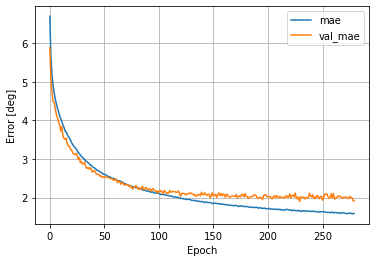

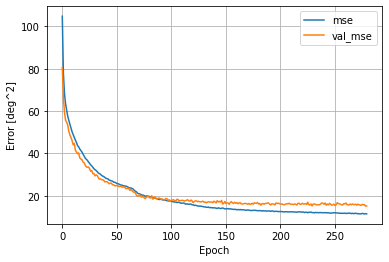

In [31]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

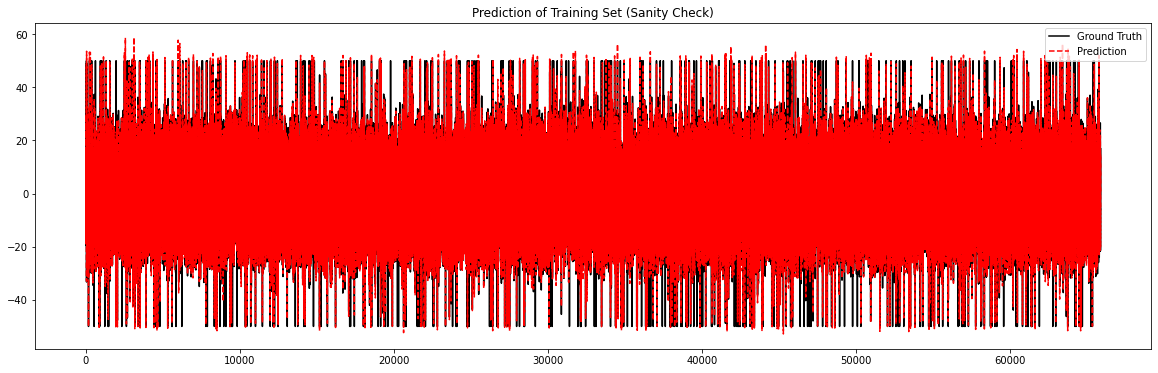

Average error is -0.08 degrees
Root Mean Squared Error is 1.03 degrees
Mean Absolute Error is 1.03 degrees


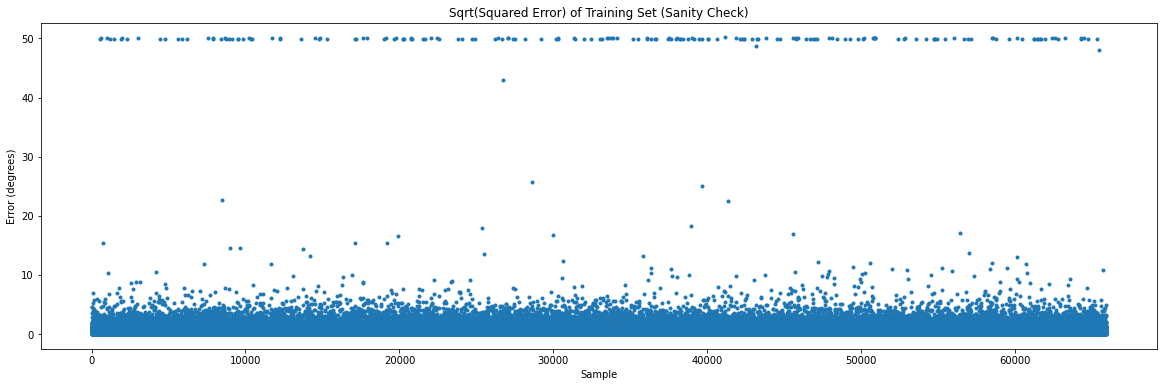

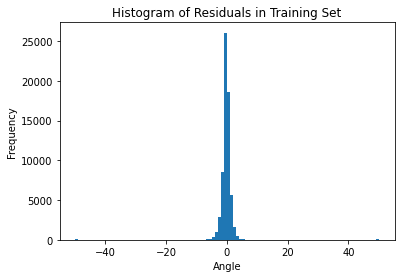

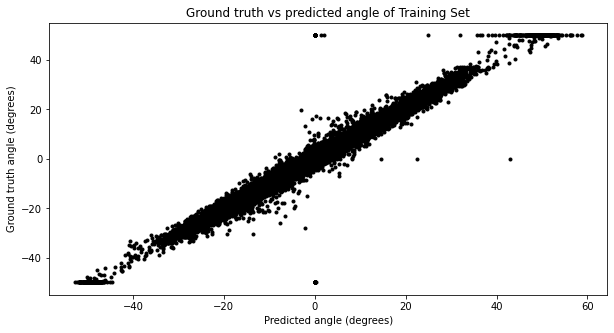

In [32]:

# sanity check with 80% data
Xtrainz = Trainset
Xtrainz2 = sc_X2.transform(Trainset2)
y_pred = model.predict([Xtrainz,Xtrainz2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

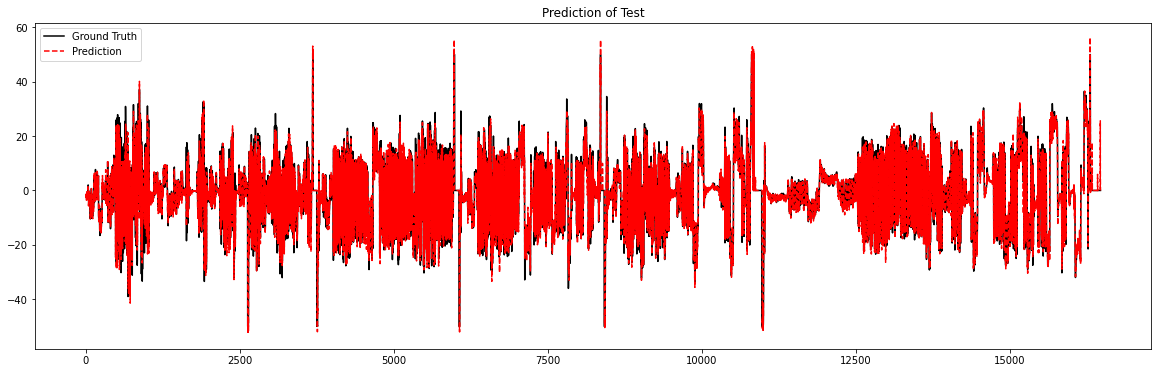

Average error is -0.05 degrees
Root Mean Squared Error is 1.90 degrees
Mean Absolute Error is 1.90 degrees


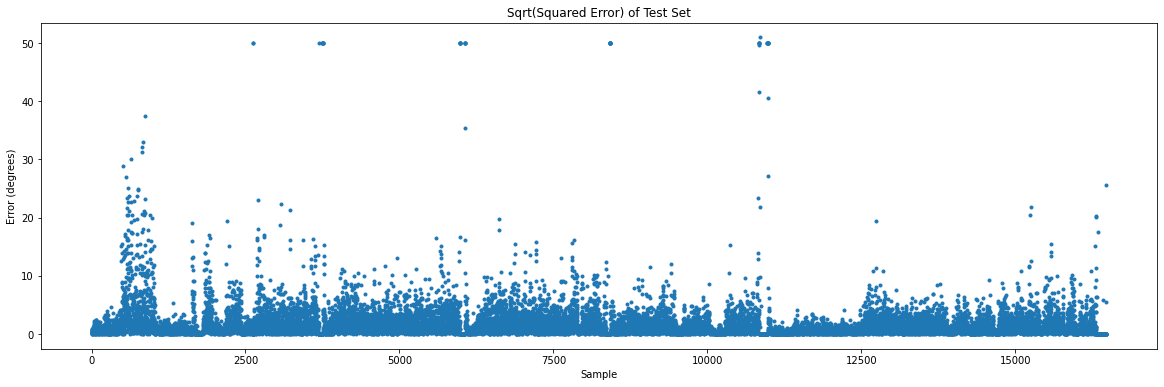

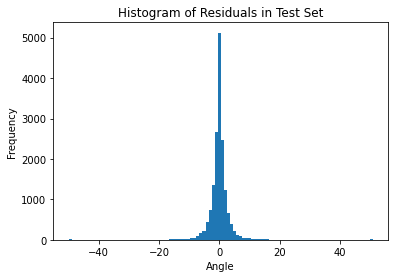

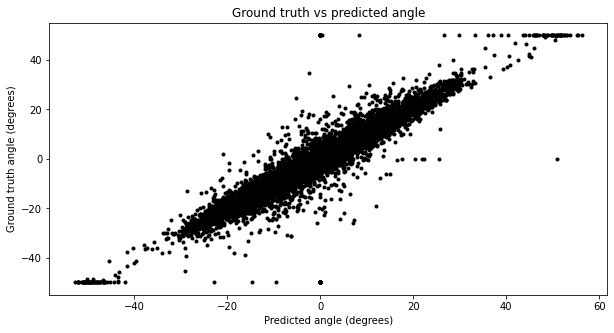

In [33]:
# Redo test set
Xtest = Testset
Xtest2 = sc_X2.transform(Testset2)
y_pred = model.predict([Xtest,Xtest2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [34]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v17.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,sc_X2,modelhistory], file)
        
    model.save('depthforcemodel_cnn3v17.h5') 